# Capacitated Facility Location Problem

In [1]:
test_name = "11 50CFLP"
sample_fraq = 0.5
randomSeed = 11


In [2]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance

# Plotting modules
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.basemap import Basemap

# Linear programming modules
import pulp

# Machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# == Regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# == Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# == Clustering
from sklearn.cluster import KMeans
from sklearn_som.som import SOM
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

# == Neural Networks
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# == Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


## Load the data

In [3]:
# import the data and parameters and check the data

data_path = "data/"
start_time = time.time()
# ====Parameters==== #
parameters = pd.read_csv(os.path.join(data_path, "parametros.csv"))
# 1. food_per_person_per_day in tons per day
food_per_person_per_day = float(
    parameters.loc[parameters["parametro"] == "comida_por_persona_en_toneladas"].values[
        0
    ][1]
)
# 2. transport_cost_per_ton_per_km in COP per ton per km
transport_cost_per_ton_per_km = float(
    parameters.loc[
        parameters["parametro"] == "costo_de_transporte_por_tonelada_por_kilomentro"
    ].values[0][1]
)

print(
    f"parameters: \n    food_per_person_per_day: {food_per_person_per_day} \n    transport_cost_per_ton_per_km: {transport_cost_per_ton_per_km}\n"
)
# ====Parameters==== #

# ====importData==== #
# 1. population, from data/municipios_procesado.csv
population = pd.read_csv(
    os.path.join(data_path, "municipios_procesado.csv"), index_col=3
)
# 2. distance, from data/distance_matrix_final.csv
distance = pd.read_csv(
    os.path.join(data_path, "distance_matrix_final.csv"), index_col=0
)
# 3. warehouses, from data/almacenes.csv
warehouses = pd.read_csv(os.path.join(data_path, "almacenes.csv"))
# ====importData==== #

# ====DataProcessing===== #
# fill the nan values in population with the minimum '2024' from the departamento of Chocó for the columns 22:
population.loc[population.isna().any(axis=1), population.columns[18:]] = (
    population[
        population["2024"]
        == population.loc[population["departamento"] == "Chocó"]["2024"].min()
    ]
    .iloc[0, 18:]
    .values
)
# drop the municipalities with nan values in the first column of the distance matrix
distance = distance.dropna(subset=[distance.columns[0]], axis=0)
distance = distance.dropna(subset=[distance.index[0]], axis=1)
# turn the columns of distance into integers
distance.columns = distance.columns.astype(int)
# Take a sample of the data
distance = distance.sample(frac=sample_fraq, random_state=randomSeed)
distance = distance.loc[
    :, distance.index
]  # make the distance matrix symmetric # type: ignore
# if there is a 0 value that is not in the diagonal, replace it with the mean of the column
for i in distance.index:
    for j in distance.columns:
        if distance.loc[i, j] == 0 and i != j:
            distance.loc[i, j] = np.nan
# Drop the nan values
distance = distance.dropna()
# make the distance matrix symmetric
distance = distance.loc[:, distance.index]
# turn distance to km
distance = distance / 1000
# select only the rows in population dpmp that the index is in distance
population = population.loc[distance.index]
# Check if every value of distance is larger than the linear distance for every pair of municipalities in population lat and lon are in the population dataframe
for i in distance.index:
    for j in distance.columns:
        if i != j:
            # get the linear distance
            linear_distance = geopy.distance.distance(
                (population.loc[i, "lat"], population.loc[i, "lon"]),
                (population.loc[j, "lat"], population.loc[j, "lon"]),
            ).km
            # check if the linear distance is larger than the distance in the distance matrix
            if linear_distance > distance.loc[i, j]:
                distance.loc[i, j] = linear_distance
# Check if there are any nan values in distance
if distance.isna().any().any():
    print("There are nan values in the distance matrix")
print(
    f"data information: \n    population: {population.shape} \n    distance: {distance.shape} \n    warehouses: \n {warehouses} \n"
)
# ====DataProcessing===== #

# ====DataInformation==== #
# Memory usage of the data
print(f"population memory usage: {population.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
print(f"distance memory usage: {distance.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
print(f"warehouses memory usage: {warehouses.memory_usage().sum()/1024**2:.2f} MB")  # type: ignore
# ====DataInformation==== #

# ====DataChecking==== #
# Test to the data if needed
# ====DataChecking==== #
print(f"Elapsed time: {time.time() - start_time:.2f} s")


parameters: 
    food_per_person_per_day: 0.00087617 
    transport_cost_per_ton_per_km: 3364.0

data information: 
    population: (544, 71) 
    distance: (544, 544) 
    warehouses: 
    Type  capacity_ton        cost
0     1          1074  3111202.75
1     2          2418  4804980.75 

population memory usage: 0.31 MB
distance memory usage: 2.28 MB
warehouses memory usage: 0.00 MB
Elapsed time: 72.64 s


## 1. Demand Forecast

we are using the data from the population dataset that has the colombian census information since 1985 to 2035, the current year is 2024 and the last census was performed in 2018, the data was taken on december 2023 from the DANE web page.

First we need to check the current forecast, then use 4 ML algorithms and Deep Learning to create a new model. The Machine Learning algorithms are:
- Multiple Linear Regression.
- Regression Tree.
- Support Vector Machine.
- Random Forest Regression.

Then, we need the Mean Absolute Error (MAE) to compare the models. The best model will be used to forecast the demand for the next 10 years.

In [4]:
# ## 1. Demand Forecast

# 1. Demand Forecast

data = population.copy().iloc[:, 20:59]
data = data.transpose()

# Standardize the data
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

# Split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=randomSeed)

# List of models to evaluate
models = {
    "Multiple Linear Regression": LinearRegression(),
    "Regression Tree": DecisionTreeRegressor(
        max_depth=100, min_samples_split=2, min_samples_leaf=1, random_state=randomSeed
    ),
    "Support Vector Machine": SVR(C=1.0, kernel="rbf", gamma="scale"),
    "Random Forest Regression": RandomForestRegressor(
        n_estimators=10,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=randomSeed,
    ),
    "Neural Network for population regression": MLPRegressor(
        hidden_layer_sizes=(10, 10, 10, 10, 10),
        activation="logistic",
        solver="adam",
        alpha=0.01,
        batch_size="auto",
        learning_rate="adaptive",
        learning_rate_init=0.01,
        max_iter=1000,
        shuffle=True,
        random_state=randomSeed,
    ),
}

best_model = None
best_score = float("-inf")
results = {}

# Iterate over models
for model_name, model in models.items():
    start_time = time.time()
    mean_absolute_errors = []
    mean_squared_errors = []
    r2_scores = []

    # For each column in the data
    for column in data.columns:
        model.fit(train.index.values.reshape(-1, 1), train[column])
        predictions = model.predict(test.index.values.reshape(-1, 1))
        mean_absolute_errors.append(mean_absolute_error(test[column], predictions))
        mean_squared_errors.append(mean_squared_error(test[column], predictions))
        r2_scores.append(r2_score(test[column], predictions))

    avg_r2_score = np.mean(r2_scores)
    results[model_name] = {
        "time": time.time() - start_time,
        "mean_absolute_error": np.mean(mean_absolute_errors),
        "mean_squared_error": np.mean(mean_squared_errors),
        "r2_score": avg_r2_score,
    }

    if avg_r2_score > best_score:
        best_score = avg_r2_score
        best_model = model

# results to dataframe
results_df = pd.DataFrame(results).transpose()
display(results_df)


print(f"\nBest model: {best_model}")

# Create the forecast per municipality since 1985 to 2024+30 years
# Create a list to store all columns
columns = []
forecast = pd.DataFrame(index=np.arange(1985, 2024 + 30))
# Iterate over each column in data
for column in data.columns:
    best_model.fit(data.index.values.reshape(-1, 1), data[column])  # type: ignore
    column_data = pd.DataFrame(
        best_model.predict(np.arange(1985, 2024 + 30).reshape(-1, 1)), columns=[column]  # type: ignore
    )
    columns.append(column_data)

# Concatenate all columns at once
forecast = pd.concat(columns, axis=1)


# Inverse the standardization
data = pd.DataFrame(
    scaler.inverse_transform(data), index=data.index, columns=data.columns  # type: ignore
)  # type: ignore
forecast = pd.DataFrame(
    scaler.inverse_transform(forecast), index=forecast.index, columns=forecast.columns  # type: ignore
)  # type: ignore
forecast.index = pd.RangeIndex(start=1985, stop=2024 + 30, step=1)

# Plot the forecast
fig = go.Figure()
for column in forecast.columns:
    fig.add_trace(
        go.Scatter(
            x=forecast.index,
            y=forecast[column],
            mode="lines+markers",
            name=column,
        )
    )

fig.update_layout(
    title="Population Forecast",
    xaxis_title="Year",
    yaxis_title="Population",
    legend_title="Municipality",
)
# fig.show()
fig.write_html(f"html/1 {test_name} forecast.html")

# Select the year 2024+10 and add the population to the population dataframe
population["forecast"] = forecast.loc[2024 + 10]


,time,mean_absolute_error,mean_squared_error,r2_score
Multiple Linear Regression,1.181877,0.281031,0.184944,-0.091882
Regression Tree,1.122259,0.128416,0.054119,0.074219
Support Vector Machine,1.112498,0.115887,0.048023,0.506857
Random Forest Regression,6.495689,0.097785,0.034201,0.457933
Neural Network for population regression,14.458209,0.692531,0.716994,-0.684142



Best model: SVR()


## 2. Set facility types

We have 3 types of facilities:
- Type 1: Small facility.
- Type 2: Medium facility.
- Type 3: Large facility.

for each facility type we have the following information:
- Fixed cost.
- Variable cost.

The proposal is to use a mathematical model to determine the number of facilities of each type to minimize the total cost, in order to satisfy the demand. and be able to train a classifier to predict the type of facility that will be needed for the hole country.


In [5]:
# Optimization of the model
p = population.copy()["forecast"]

# ====Parameters==== #
c_j = warehouses["capacity_ton"].values.astype(float)
f_j = warehouses["cost"].values.astype(float)


p_i = p.values.astype(int)
n = food_per_person_per_day * 7
d_i = p_i * n
# Lambda = 2 for the top 32 municipalities, 1 for the rest
lambda_i = np.ones(len(p_i)) * 1.1
lambda_i[np.argsort(p_i)[-32:]] = 1.5
# ====Parameters==== #


# Decision variables: $x_{ij}$
I = range(len(p_i))
J = range(len(c_j))
model = pulp.LpProblem("UFLP", pulp.LpMinimize)
x = pulp.LpVariable.dicts(
    "x", ((i, j) for i in I for j in J), lowBound=0, cat="Integer"
)
y = pulp.LpVariable.dicts("y", ((i, j) for i in I for j in J), cat="Binary")
# Objective function
model += (
    pulp.lpSum(f_j[j] * x[(i, j)] for i in I for j in J),
    "Total cost of the facilities",
)
# Constraints
for i in I:
    model += (
        pulp.lpSum(c_j[j] * x[(i, j)] for j in J) >= d_i[i] * lambda_i[i],
        f"Population demand {i}",
    )
    model += (
        pulp.lpSum(x[(i, j)] for j in J) >= 1,
        f"Facility assignment {i}",
    )
    model += (
        pulp.lpSum(y[(i, j)] for j in J) == 1,
        f"Faacility assignment __ {i}",
    )
    for j in J:
        model += (
            x[(i, j)] <= 100 * y[(i, j)],
            f"Fsacility assignment _ {i} _ {j}",
        )

model += pulp.lpSum(x[(i, j)] * c_j[j] for i in I for j in J) >= pulp.lpSum(
    d_i[i] * lambda_i[i] for i in I
)


# Solve the model
model.solve(
    solver=pulp.PULP_CBC_CMD(
        logPath=f"logs/2 {test_name}.log",
        msg=False,
        timeLimit=5 * 60,
        threads=os.cpu_count(),
    )
)
# Results
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Objective function: {pulp.value(model.objective)}")
df = pd.DataFrame(
    [[pulp.value(x[(i, j)]) for j in J] for i in I],
    columns=[f"Facility {j}" for j in J],
    index=p.index,
)
df["demand"] = d_i
df["satisfied"] = sum(df[f"Facility {j}"] * c_j[j] for j in J)
df["cost"] = sum(df[f"Facility {j}"] * f_j[j] for j in J)
df["comb"] = df.apply(lambda x: tuple(x[: len(J)]), axis=1)

display("Clasifications:", df.comb.unique().size, df.comb.unique())


Status: Optimal
Objective function: 1851023002.25


'Clasifications:'

7

array([(1.0, 0.0), (0.0, 1.0), (3.0, 0.0), (0.0, 2.0), (0.0, 3.0),
       (0.0, 5.0), (0.0, 4.0)], dtype=object)

## 3. Set facility capacity

We have m types of facilities with different capacities, the proposal is to use the data generated in the previous step to determine the capacity of each facility type in order to satisfy the demand.
Machine Learning algorithms will be used to Classify the type of facility that will be needed for each municipality.
- Decision Tree.
- Linear Discriminant Analysis.
- Logistic Regression.
- Support Vector Machine.

and deep learning to create a new model. The best model will be used to determine the capacity of each facility type.

The objective is to predict 'satisfied' with the demand of each municipality.


In [6]:
data = pd.merge(df.copy(), population.copy(), left_index=True, right_index=True)
population["demand"] = d_i
population["_satisfied"] = df["satisfied"]
population["_cost"] = df["cost"]


data = data[["demand", "lat", "lon", "satisfied", "cost"]]

# Create table with the unique cases of satisfied and cost values, with a random sample of n of the demand, lat and lon
unique_cases = data.groupby(["satisfied", "cost"]).apply(
    lambda x: x.sample(n=2, random_state=randomSeed) if len(x) > 2 else x
)
data = unique_cases.reset_index(drop=True)[["demand", "satisfied"]]
display(data)
le = LabelEncoder()
data["satisfied"] = le.fit_transform(data["satisfied"])
scaler = MinMaxScaler()
data[["demand"]] = scaler.fit_transform(data[["demand"]])
train_x, test_x, train_y, test_y = train_test_split(
    data.drop(columns=["satisfied"]), data["satisfied"], test_size=0.2, random_state=0
)

train_x, test_x = data.drop(columns=["satisfied"]), data.drop(columns=["satisfied"])
train_y, test_y = data["satisfied"], data["satisfied"]

# List of models to evaluate
models = {
    "Decision Tree": DecisionTreeClassifier(
        max_depth=100, min_samples_split=2, min_samples_leaf=1
    ),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(C=1.0, kernel="rbf", gamma="scale"),
    "Deep Neural Network": MLPClassifier(
        hidden_layer_sizes=(100, 100, 100),
        activation="relu",
        solver="adam",
        max_iter=1000,
        random_state=0,
    ),
}

best_model = None
best_score = float("-inf")
results = {}
metrics = {
    "accuracy": [],
    "confusion_matrix": [],
    "classification_report": [],
    "time": [],
}

# Iterate over models
for model_name, model in models.items():
    start_time = time.time()
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    accuracy = accuracy_score(test_y, predictions)
    confusion = confusion_matrix(test_y, predictions)
    classification = classification_report(test_y, predictions, zero_division=0)
    results[model_name] = {
        "time": time.time() - start_time,
        "accuracy": accuracy,
        "confusion_matrix": confusion,
        "classification_report": classification,
    }

    if accuracy > best_score:
        best_score = accuracy
        best_model = model

    metrics["accuracy"].append(accuracy)
    metrics["confusion_matrix"].append(confusion)
    metrics["classification_report"].append(classification)
    metrics["time"].append(time.time() - start_time)

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics['time']:.2f} s")
    print(f"    Accuracy: {metrics['accuracy']}")
    print(f"    Confusion Matrix: {metrics['confusion_matrix']}")
    print(f"    Classification Report: {metrics['classification_report']}")

print(f"\nBest model: {best_model}")

# Classify the data for the population data for every model
for model_name, model in models.items():
    population[f"_satisfied {model_name}"] = model.predict(population[["demand"]])
    population[f"_satisfied {model_name}"] = le.inverse_transform(
        population[f"_satisfied {model_name}"]
    )


/tmp/ipykernel_97161/3952257875.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,demand,satisfied
0,160.137591,1074.0
1,26.188721,1074.0
2,1010.878509,2418.0
3,874.893420,2418.0
4,1834.093670,3222.0
5,1694.391869,3222.0
6,2718.364738,4836.0
7,3185.713816,4836.0
8,3331.137884,7254.0
9,4250.392668,7254.0


Decision Tree: 0.01 s
    Accuracy: 1.0
    Confusion Matrix: [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]]
    Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Linear Discriminant Analysis: 0.01 s
    Accuracy: 0.9166666666666666
    Confusion Matrix: [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0]


## 5. Solve the CFLP


In [7]:
data = population.copy()[
    [
        "demand",
        "_satisfied",
        "_cost",
        "lat",
        "lon",
    ]
]
dist = distance.copy()

print(f"size: {data.shape}")

h_i = data["demand"].values  # demand of customer i
c_ij = (
    dist.loc[data.index, data.index] * transport_cost_per_ton_per_km  # type: ignore
).values  # distance between customer i and j
f_j = data["_cost"].values  # fixed cost to open a facility at site j
v_j = data[
    "_satisfied"
].values  # maximum capacity of facility j or the amount of capacity that it can be satisfied

# Inside the loop, for testing we will work with the last group
## Create the variables
I = range(len(h_i))
J = range(len(f_j))
x_j = pulp.LpVariable.dicts("x", J, cat="Binary")
y_ij = pulp.LpVariable.dicts(
    "y", ((i, j) for i in I for j in J), lowBound=0, upBound=1, cat="Continuous"
)
## Create the model
model = pulp.LpProblem("CFLP", pulp.LpMinimize)
## Objective function
model += (
    pulp.lpSum(f_j[j] * x_j[j] for j in J)
    + pulp.lpSum(c_ij[i][j] * y_ij[(i, j)] for i in I for j in J),
    "Total cost",
)
## Constraints
for i in I:
    model += pulp.lpSum(y_ij[(i, j)] for j in J) == 1, f"Population demand {i}"
for j in J:
    for i in I:
        model += y_ij[(i, j)] <= x_j[j], f"Facility assignment {i} {j}"
for j in J:
    model += (
        pulp.lpSum(h_i[i] * y_ij[(i, j)] for i in I) <= v_j[j],
        f"Facility capacity {j}",
    )
# Save the parameters to an excel file where each sheet is parameter h, c, f, v
df_h = pd.DataFrame(h_i, columns=["demand"], index=data.index)
df_c = pd.DataFrame(c_ij, columns=data.index, index=data.index)
df_f = pd.DataFrame(f_j, columns=["cost"], index=data.index)
df_v = pd.DataFrame(v_j, columns=["capacity"], index=data.index)

with pd.ExcelWriter(f"parameters/{test_name}.xlsx") as writer:
    df_h.to_excel(writer, sheet_name="demand")
    df_c.to_excel(writer, sheet_name="distance")
    df_f.to_excel(writer, sheet_name="cost")
    df_v.to_excel(writer, sheet_name="capacity")
del df_h, df_c, df_f, df_v

## Solve the model
print(f"----- {test_name} ----- || size {c_ij.shape} || Current time: {time.time()}")
start_time = time.time()
model.solve(
    solver=pulp.PULP_CBC_CMD(
        logPath=f"logs/5 {test_name}.log",
        msg=False,
        timeLimit=60 * 60,
        threads=os.cpu_count(),
    )
)
## Results
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Objective function: {pulp.value(model.objective)}")
print(f"Number of facilities: {pulp.value(pulp.lpSum(x_j[j] for j in J))}")
print(f"Solution time: {time.time() - start_time :.2f} s")
## Save the solution
df_y = pd.DataFrame(
    [[pulp.value(y_ij[(i, j)]) for j in J] for i in I],
    data.index,
    data.index,
)
df_x = pd.DataFrame([pulp.value(x_j[j]) for j in J], columns=["open"], index=data.index)
with pd.ExcelWriter(
    f"solutions/{test_name} {pulp.value(model.objective)}.xlsx"
) as writer:
    df_y.to_excel(writer, sheet_name="Y")
    df_x.to_excel(writer, sheet_name="X")


del x_j, y_ij, I, J, h_i, c_ij, f_j, v_j


# 5. plot the results of the CFLP in a map with the contours of Colombia
fig = go.Figure()
## Add the municipalities and the color with the cluster to which they belong
fig.add_trace(
    go.Scattermapbox(
        lat=data["lat"],
        lon=data["lon"],
        mode="markers",
        marker=dict(
            size=(data["demand"] / max(data["demand"])) * 30,
            color="grey",
            colorscale="twilight",
        ),
        text=[
            f"{i}\n {data.loc[i, 'demand']}\n {data.loc[i, '_cost']}"
            for i in data.index
        ],
    )
)

# Add the arrows that show the amount of the demand that each facility satisfies
for i in data.index:
    for j in data.index:
        if df_y.loc[i, j] > 0:
            fig.add_trace(
                go.Scattermapbox(
                    lat=[data.loc[i, "lat"], data.loc[j, "lat"]],
                    lon=[data.loc[i, "lon"], data.loc[j, "lon"]],
                    mode="lines",
                    line=dict(width=df_y.loc[i, j] * 5, color="orange"),
                    opacity=df_y.loc[i, j],
                )
            )
# Add the Open facilitys
for j in data.index:
    if int(df_x.loc[j, "open"]) > 0:  # type: ignore
        fig.add_trace(
            go.Scattermapbox(
                lat=[data.loc[j, "lat"]],
                lon=[data.loc[j, "lon"]],
                mode="markers",
                marker=dict(size=10, color="red"),
                text=f"{j}",
            )
        )

fig.update_layout(
    title=f"CFLP {pulp.value(model.objective)}",
    mapbox=dict(
        style="carto-positron",
        center=dict(lon=-74, lat=4),
        zoom=4,
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=0, b=0),
)
# fig.show()


size: (544, 5)
----- 11 50CFLP ----- || size (544, 544) || Current time: 1716580978.1560838


In [ ]:
# Save the html
fig.write_html(f"solutions/6 {test_name}.html")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


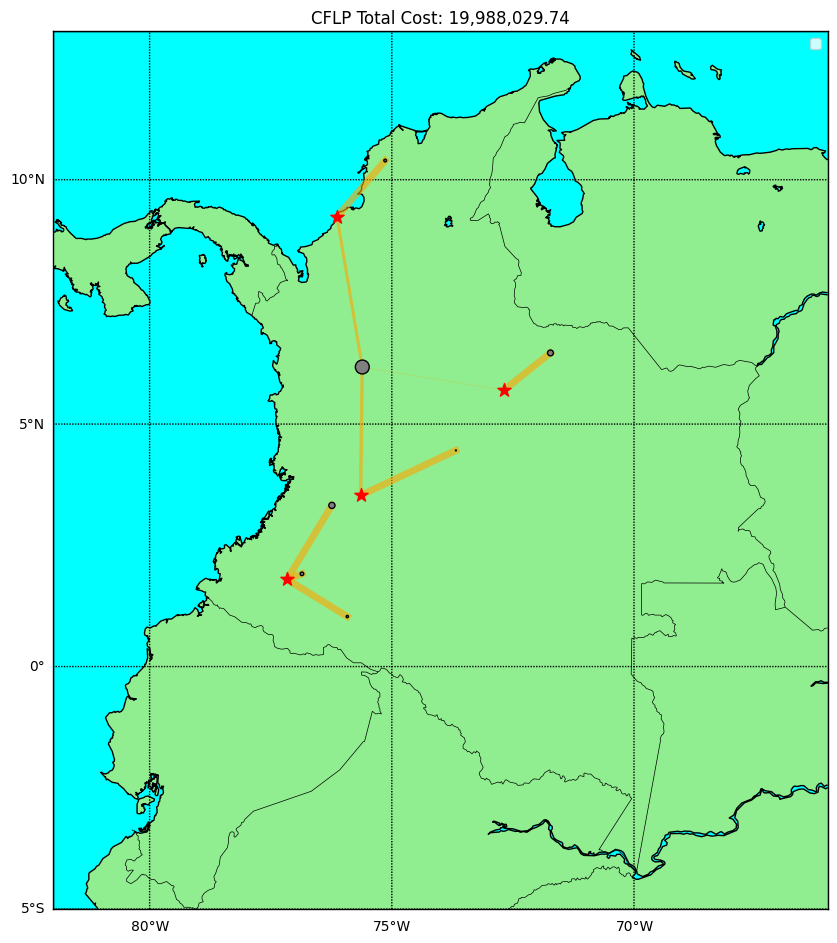

In [ ]:
fig, ax = plt.subplots(figsize=(10, 15))
m = Basemap(
    projection="merc",
    llcrnrlat=-5,
    urcrnrlat=13,
    llcrnrlon=-82,
    urcrnrlon=-66,
    lat_ts=0,
    resolution="i",
    ax=ax,
)
m.drawcountries()
m.drawmapboundary(fill_color="aqua")
m.fillcontinents(color="lightgreen", lake_color="aqua")
m.drawcoastlines()
m.drawparallels(range(-10, 20, 5), labels=[1, 0, 0, 0])
m.drawmeridians(range(-90, -60, 5), labels=[0, 0, 0, 1])

# Plot municipalities
x, y = m(data["lon"].values, data["lat"].values)
m.scatter(
    x,
    y,
    s=(data["demand"] / max(data["demand"])) * 100,
    color="grey",
    edgecolor="k",
    zorder=5,
)

# Plot demand satisfaction arrows
for i in data.index:
    for j in data.index:
        if df_y.loc[i, j] > 0:
            start_lat = data.loc[i, "lat"]
            start_lon = data.loc[i, "lon"]
            end_lat = data.loc[j, "lat"]
            end_lon = data.loc[j, "lon"]
            x_start, y_start = m(start_lon, start_lat)
            x_end, y_end = m(end_lon, end_lat)
            m.plot(
                [x_start, x_end],
                [y_start, y_end],
                color="orange",
                linewidth=df_y.loc[i, j] * 5,
                alpha=0.6,
                zorder=4,
            )

# Plot open facilities
for j in data.index:
    if int(df_x.loc[j, "open"]) > 0:
        x, y = m(data.loc[j, "lon"], data.loc[j, "lat"])
        m.scatter(x, y, color="red", s=100, marker="*", zorder=6)

plt.legend()
plt.title(f"CFLP Total Cost: {pulp.value(model.objective):,.2f}")
plt.show()
